In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "xformers<0.0.26" trl peft accelerate bitsandbytes

In [4]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 32000 # 2048
# dtype = torch.float16 # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
dtype = torch.bfloat16 # Bfloat16 for L4
load_in_4bit = True # Use 4bit quantization to reduce memory usage

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/tinyllama-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Device does not support bfloat16. Will change to float16.


==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: unsloth/tinyllama-bnb-4bit can only handle sequence lengths of at most 2048.
But with kaiokendev's RoPE scaling of 15.625, it can be magically be extended to 32000!


model.safetensors:   0%|          | 0.00/762M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 22 layers with 22 QKV layers, 22 O layers and 22 MLP layers.


In [6]:
import random
from datasets import DatasetDict, load_dataset, Dataset

# Load the dataset
data_dict = load_dataset("csv", data_files="/content/drive/Shareddrives/CS_685_Project/PantryData/final_dataset.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
alpaca_prompt = """Below is an instruction that describes a user's interaction history with products on Amazon. Write a response that appropriately completes the request.

### Instruction:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["prompts"]
    # inputs       = examples["input"]
    outputs      = examples["outputs"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

data_dict = data_dict['train'].train_test_split(test_size=0.2)
data_dict = data_dict.map(formatting_prompts_func, batched=True,)

Map:   0%|          | 0/9914 [00:00<?, ? examples/s]

Map:   0%|          | 0/2479 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer).

In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    # train_dataset = dataset,  # original code
    # train_dataset = dataset_reviews_abridged,  # testing w abridged mock data
    train_dataset = data_dict['train'],
    eval_dataset = data_dict['test'],
    dataset_text_field = "text",  # originally 'text'
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences
    args = TrainingArguments(
        do_eval = True,
        evaluation_strategy = "epoch",
        num_train_epochs=5,
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 1,  # Number of updates steps to accumulate the gradients for, before performing a backward/update pass
        warmup_steps = 3, # Number of steps used for a linear warmup from 0 to learning_rate
        # max_steps = 60, # Set num_train_epochs = 1 for full training runs; original code
        learning_rate = 1e-3, # originally 2e-4
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,  # this logs the losses per epoch
        optim = "adamw_8bit",
        weight_decay = 0.001,  # Weight_decay of .00001 was too low and losses were stagnant; .0001 was good and losses reduced; .001 also worked well; .01 also worked well
                              # Going with .01 because it's high, but not too high. Model will continue to learn and be regularized
        # lr_scheduler_type = "linear",   # defaults to "linear"
        seed = 3407,
        output_dir = "/content/drive/Shareddrives/CS_685_Project/outputs",
        dataloader_num_workers=4,
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/2479 [00:00<?, ? examples/s]

In [13]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
2.104 GB of memory reserved.


In [14]:
trainer_stats = trainer.train()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,0.627200,0.691961
2,0.365500,0.525095
3,0.374600,0.423947
4,0.320800,0.372932
5,0.283600,0.355217


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os

In [ ]:
trainer_stats = trainer.train() # Step, above results - Epochs

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,914 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 1
\        /    Total batch size = 8 | Total steps = 6,200
 "-____-"     Number of trainable parameters = 12,615,680
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss
1,6.100800
2,6.208100
3,5.877800
4,5.235700
5,4.980200
6,4.590200
7,4.128000
8,3.695200
9,3.478800
10,3.103000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possibl

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3095.1205 seconds used for training.
51.59 minutes used for training.
Peak reserved memory = 1.656 GB.
Peak reserved memory for training = 0.722 GB.
Peak reserved memory % of max memory = 7.47 %.
Peak reserved memory for training % of max memory = 3.257 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
print(data_dict)
print("INSTRUCTION", data_dict['test']['prompts'][3])
print("OUTPUT", data_dict['test']['outputs'][3])
print("TEXT", data_dict['test']['text'][3])

DatasetDict({
    train: Dataset({
        features: ['prompts', 'outputs', 'text'],
        num_rows: 9914
    })
    test: Dataset({
        features: ['prompts', 'outputs', 'text'],
        num_rows: 2479
    })
})
INSTRUCTION Reviewer has bought White Premium Chunk Chicken Ounce Pack of, Ocean Spray Dried Ounce, Pop Breakfast Toaster Frosted Brown Sugar Cinnamon Family Count, Chicken of the Sea Premium Skinless and Boneless Pink Ounce. Considering their purchase history, which product will they buy next from the below options?  A) Dark and Lovely AU Natural Anti-Breakage Root to Tip Mender, 4 Fluid Ounce, B) Woodstock All-natural Almond Butter, Smooth, Unsalted, 16 oz, C) Pop-Tarts Toaster Pastries, Frosted Blue Raspberry, 8 Count, D) Original Ounce.
OUTPUT Original Ounce
TEXT Below is an instruction that describes a user's interaction history with products on Amazon. Write a response that appropriately completes the request.

### Instruction:
Reviewer has bought White Premium Chun

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        data_dict['test']['prompts'][3], # instruction
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 512, use_cache = True) # play with max_new_tokens to optimize output length
tokenizer.batch_decode(outputs)

["<s> Below is an instruction that describes a user's interaction history with products on Amazon. Write a response that appropriately completes the request.\n\n### Instruction:\nReviewer has bought White Premium Chunk Chicken Ounce Pack of, Ocean Spray Dried Ounce, Pop Breakfast Toaster Frosted Brown Sugar Cinnamon Family Count, Chicken of the Sea Premium Skinless and Boneless Pink Ounce. Considering their purchase history, which product will they buy next from the below options?  A) Dark and Lovely AU Natural Anti-Breakage Root to Tip Mender, 4 Fluid Ounce, B) Woodstock All-natural Almond Butter, Smooth, Unsalted, 16 oz, C) Pop-Tarts Toaster Pastries, Frosted Blue Raspberry, 8 Count, D) Original Ounce.\n\n### Response:\nOriginal Ounce</s>"]

In [15]:
test_data_x = data_dict['test']['prompts']
test_data_y = data_dict['test']['outputs']

FastLanguageModel.for_inference(model)

test_output = []

for i in test_data_x:
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            i, # instruction
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 1024, use_cache = True) # play with max_new_tokens to optimize output length
    t = tokenizer.batch_decode(outputs)
    instruction_string = t[0]
    start_index = instruction_string.find("Response:\n") + len("Response:\n")
    end_index = instruction_string.find("</s>")
    response = instruction_string[start_index:end_index]
    test_output.append(response)

In [16]:
import csv

filename = "/content/drive/Shareddrives/CS_685_Project/final_generated_output.csv"
with open(filename, mode='w', newline='') as file:
    for string in test_output:
        file.write(string + '\n')

In [20]:
print(test_data_y)

['It Baked Snack Box', 'Jell Devil Food Instant Pudding Mix Ounce Box', 'Blue Diamond Oven Cocoa Ounce', 'Original Ounce', 'Country Time Flavored Drink Black Cherry Ounce Container', 'Condensed Chicken Noodle Pack of', 'Seventh Generation Organic Cotton Super Plus Absorbency Non count', 'Dawn Ultra Dishwashing Liquid Dish Soap Original two', 'Blue Diamond Nut Cracker Hint of Sea Ounce', 'Old Spice High Endurance Long Lasting Stick Invisible Solid Men and Fresh Scent', 'of Pure Peppermint Herbal Tea for Count', 'Jell Raspberry Gelatin Mix Ounce Box', 'Chewy Peanut Peanut Non Project Count', 'Slim Snack Sized Smoked Meat Original Count', 'Minute Maid Lemonade Made Real Pack', 'Onion Flavored Ounce', 'Acne Control Face may vary', 'Iced Tea Pound Ounce', 'Curry Sauce with Ounce', 'OPTIMUM NUTRITION GOLD STANDARD Whey Protein Mocha Pound', 'Poly Frequency Expanding Flap and Cord Letter Blue Black', 'in Olive Solid Light Ounce Pack of', 'Jack Link Beef Sweet Ounce', 'Ounce', 'Calorie Sea Cou

In [23]:
df = pd.DataFrame(test_data_y, columns=["Strings"])

# Export the DataFrame to an Excel file
df.to_excel("ground_truth.xlsx", index=False)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_predictions(ground_truth, test_output):

    ground_truth = ["" if item is None else item for item in ground_truth]
    test_output = ["" if item is None else item for item in test_output]

    # Accuracy
    accuracy = accuracy_score(ground_truth, test_output)

    # Precision
    precision = precision_score(ground_truth, test_output, average='weighted')

    # Recall
    recall = recall_score(ground_truth, test_output, average='weighted')

    # F1 Score
    f1 = f1_score(ground_truth, test_output, average='weighted')

    # Exact Match
    exact_match = sum(1 for x, y in zip(ground_truth, test_output) if x == y) / len(ground_truth)

    # Confusion Matrix
    confusion_mat = confusion_matrix(ground_truth, test_output)

    return accuracy, precision, recall, f1, exact_match, confusion_mat

accuracy, precision, recall, f1, exact_match, confusion_mat = evaluate_predictions(test_data_y, test_output)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Exact Match:", exact_match)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.9850746268656716
Precision: 0.9856797095603066
Recall: 0.9850746268656716
F1 Score: 0.9852897673793196
Exact Match: 0.9850746268656716
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model.save_pretrained("/content/drive/Shareddrives/CS_685_Project/final_model") # Local saving
tokenizer.save_pretrained("/content/drive/Shareddrives/CS_685_Project/final_model")

('/content/drive/Shareddrives/CS_685_Project/final_model/tokenizer_config.json',
 '/content/drive/Shareddrives/CS_685_Project/final_model/special_tokens_map.json',
 '/content/drive/Shareddrives/CS_685_Project/final_model/tokenizer.model',
 '/content/drive/Shareddrives/CS_685_Project/final_model/added_tokens.json',
 '/content/drive/Shareddrives/CS_685_Project/final_model/tokenizer.json')

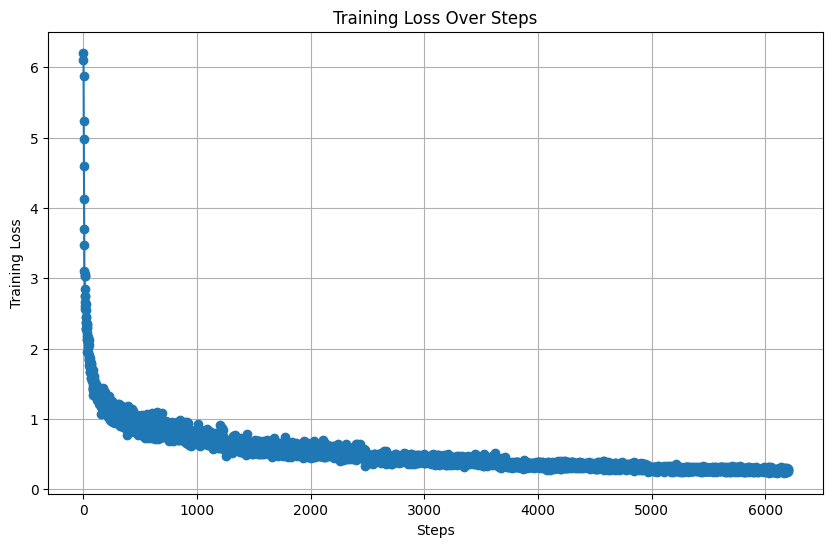

In [ ]:
df_loss = pd.read_excel("loss.xlsx")

steps = df_loss['Step']
training_loss = df_loss['Training Loss']

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o', linestyle='-')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

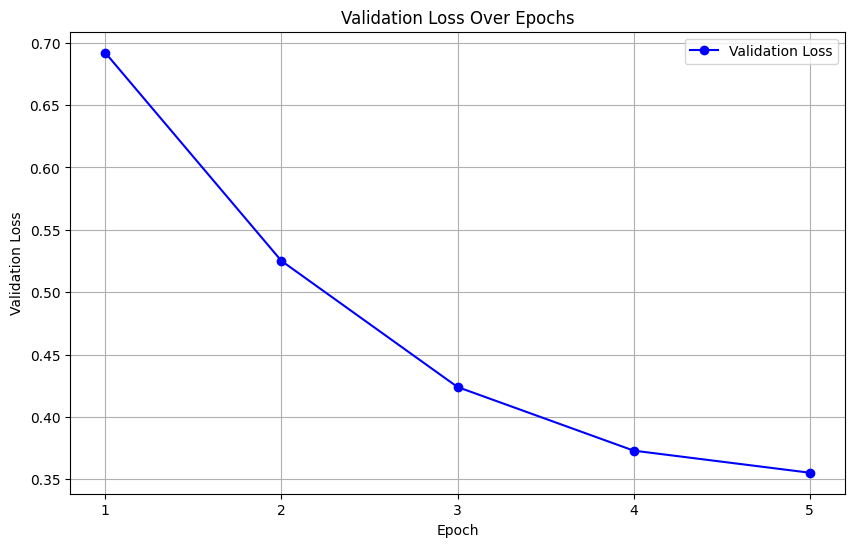

In [22]:
# Validation loss values generated from another code file when the evaluation parameter was set to true while training
validation_loss = [0.691961, 0.525095, 0.423947, 0.372932, 0.355217]

# Number of epochs
epochs = list(range(1, len(validation_loss) + 1))

# Plotting the validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, validation_loss, marker='o', linestyle='-', color='b', label='Validation Loss')

# Adding title and labels
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.xticks(epochs)  # Ensures each epoch is represented on the x-axis
plt.grid(True)
plt.legend()

# Show the plot
plt.show()